In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from numpy.random import rand, choice
npop = 100
nsets = 10
Cmat = (rand(nsets,npop) > rand(nsets, 1)) + 0.0

In [7]:
csizes = np.sum(Cmat, 1)

In [8]:
nsub = 30
csizes_scale = (csizes * nsub/npop)
csizes_scale = csizes_scale.reshape((-1, 1))
csizes_scale.shape

(10, 1)

In [11]:
nrestarts = 20
ops.reset_default_graph()
lam_bin = tf.placeholder(dtype = tf.float32, shape = ())
lam_count = tf.placeholder(dtype = tf.float32, shape = ())
lam_loss = tf.placeholder(dtype = tf.float32, shape = ())
pre_x = tf.get_variable(dtype = tf.float32, shape = (npop, nrestarts), name = 'pre_x',
                     initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1))
x = tf.nn.sigmoid(pre_x * 200)
C = tf.constant(Cmat, dtype = tf.float32)
cs = tf.constant(csizes_scale, dtype = tf.float32)
#pen_bin = tf.reduce_sum((.25 - (.5 - x)**2)**2)
pen_bin = tf.reduce_sum(tf.math.minimum(tf.math.abs(x), tf.math.abs(x - 1)))
pen_count = tf.reduce_sum((tf.reduce_sum(x, axis=0) - nsub)**2)
#pen_count = tf.reduce_sum(tf.math.maximum(0.0, tf.reduce_sum(x, axis=0) - nsub))
loss = tf.reduce_sum((tf.matmul(C, x) - cs)**2)
#objf = lam_loss * loss + lam_bin * pen_bin + lam_count * pen_count
objf = loss + lam_count * pen_count

In [12]:
opt = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
grads = opt.compute_gradients(objf)
apply_gradient_op = opt.apply_gradients(grads)

In [14]:
nits = 20000
with tf.Session() as sess:
    tf.global_variables_initializer().run(session=sess)
    for it_no in range(nits):
        #lam_bin_v = 100 * np.power(30 + it_no, 0.7)
        lam_count_v = 100  #100 * np.power(1 + it_no, 0.5)
        #lam_loss_v = 0 # 200/(200 + it_no)
        l, o, pb, pc, _ = sess.run([loss, objf, pen_bin, pen_count, apply_gradient_op], 
                           feed_dict={lam_count:lam_count_v})
        if it_no % 1000 == 0:
            print({'objf':o, 'loss':l, 'pen_bin': pb, 'pen_count': pc})
    x_found = sess.run(x)

{'objf': 931524.1, 'loss': 32226.752, 'pen_bin': 57.71227, 'pen_count': 8992.974}
{'objf': 440.68448, 'loss': 438.00024, 'pen_bin': 25.398727, 'pen_count': 0.026842382}
{'objf': 292.69345, 'loss': 291.5839, 'pen_bin': 28.560104, 'pen_count': 0.011095585}
{'objf': 176.63156, 'loss': 175.91963, 'pen_bin': 39.045525, 'pen_count': 0.007119294}
{'objf': 111.47235, 'loss': 111.071976, 'pen_bin': 45.58642, 'pen_count': 0.0040037506}
{'objf': 90.65506, 'loss': 90.39404, 'pen_bin': 48.260056, 'pen_count': 0.002610201}
{'objf': 77.78731, 'loss': 77.58413, 'pen_bin': 51.923115, 'pen_count': 0.0020317694}
{'objf': 71.539055, 'loss': 71.33188, 'pen_bin': 53.5129, 'pen_count': 0.0020717606}
{'objf': 70.29784, 'loss': 70.01489, 'pen_bin': 54.73498, 'pen_count': 0.0028294655}
{'objf': 69.78015, 'loss': 69.29732, 'pen_bin': 55.395676, 'pen_count': 0.004828376}
{'objf': 69.27354, 'loss': 69.020744, 'pen_bin': 54.56006, 'pen_count': 0.002527898}
{'objf': 69.414795, 'loss': 68.91717, 'pen_bin': 53.76537, 

(array([1329.,   22.,   21.,   13.,   19.,   16.,   20.,   11.,   14.,
         535.]),
 array([3.3992851e-28, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

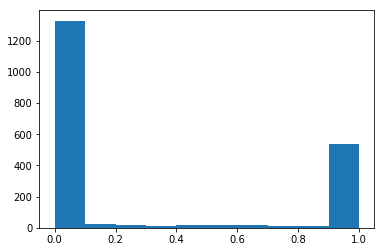

In [15]:
plt.hist(x_found.ravel())

In [16]:
x_round = (x_found > 0.5) + 0.0

In [17]:
np.sum(x_found, 0)

array([30.01101 , 30.00278 , 30.022713, 30.00004 , 29.996262, 30.005054,
       29.999863, 29.999834, 29.973593, 29.999826, 30.00569 , 29.994404,
       29.993671, 30.029076, 29.999914, 30.003017, 29.993147, 30.005724,
       30.004831, 30.000038], dtype=float32)

In [18]:
np.sum(x_round, 0)

array([29., 29., 31., 29., 31., 29., 30., 29., 30., 29., 30., 31., 30.,
       30., 29., 30., 30., 30., 30., 30.])

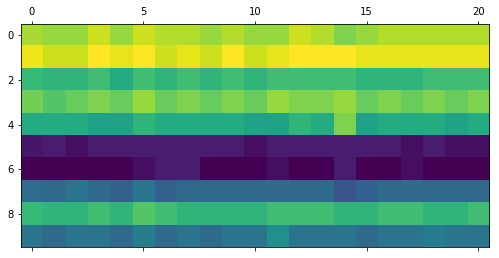

In [22]:
plt.matshow(np.concatenate((csizes_scale, np.matmul(Cmat, x_round)), axis=1))